# Relax Data Science Challenge
## Importing required Libraries and the Data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
sns.set(style="whitegrid")


In [2]:
#get users data into a dataframe
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
session = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
print(session.info())
session.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Data Wrangling and EDA

In [4]:
#session['user_id'].drop_duplicates().shape

In [5]:
session['time_stamp'] = pd.to_datetime(session['time_stamp']) - pd.to_timedelta(7, unit='d')
session.head()

,time_stamp,user_id,visited
0,2014-04-15 03:53:30,1,1
1,2013-11-08 03:45:04,2,1
2,2013-11-22 03:45:04,2,1
3,2013-12-02 03:45:04,2,1
4,2013-12-18 03:45:04,2,1


In [6]:
#calculate weekly session by user and get maximum no of session in a day for user as a time series object.

ses_stats = pd.Series([])
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = session.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [7]:
# get invited users

invited_users = users[users['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)


In [8]:
# get daily Adopted user based on no of session

users['adopted_user'] = users['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)
users['adopted_user'].value_counts()
users['invited'] = users['object_id'].apply(lambda x: 1 if x in invited_users else 0)

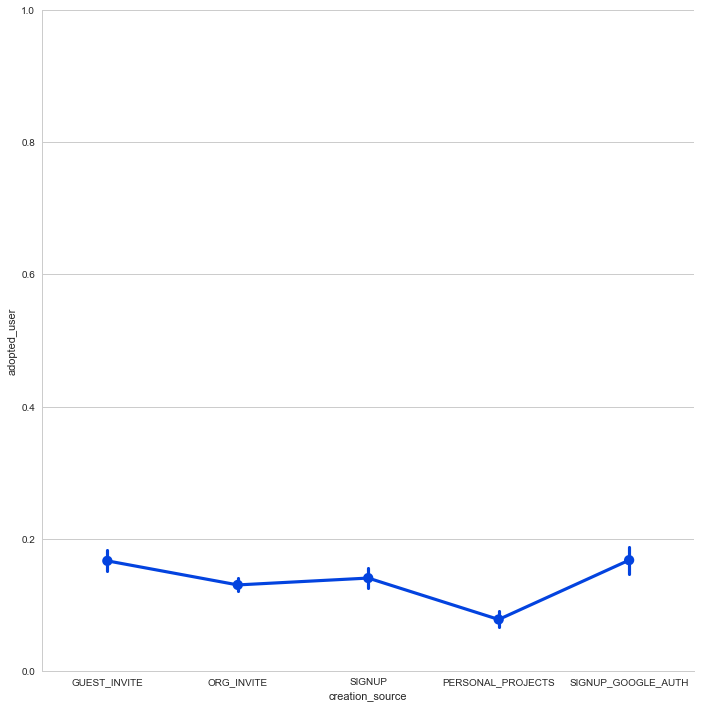

In [9]:
# plot Adopted user frequency by source of creation

g = sns.PairGrid(data=users, x_vars=['creation_source'], y_vars='adopted_user', size=10)
g.map(sns.pointplot, color=sns.xkcd_rgb["blue"])
g.set(ylim=(0, 1))


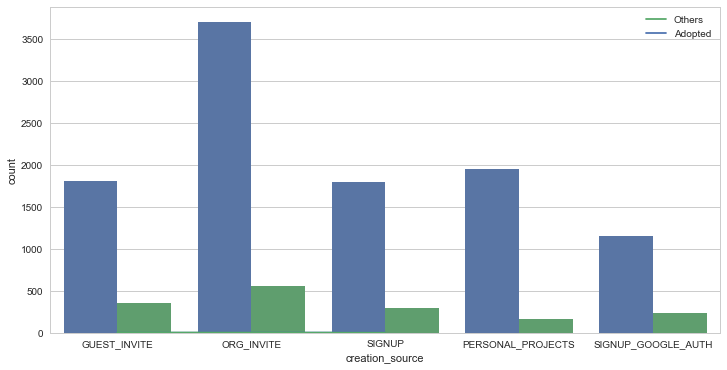

In [10]:
# plot Adopted user and not adopted user count

plt.figure(figsize=(12,6))
sns.countplot(x='creation_source', data=users, hue='adopted_user')

adopted, = plt.plot([1,2,3], label='Adopted')
no_adopted, = plt.plot([3,2,1],  label='Others')
plt.legend([no_adopted, adopted], ['Others', 'Adopted'])

People with **Personal Projects** are extremely less likely to be an adopted user as compared to other creation source methods. But since this does not help us in identifying adopted users, this too, isn't a very useful feature.

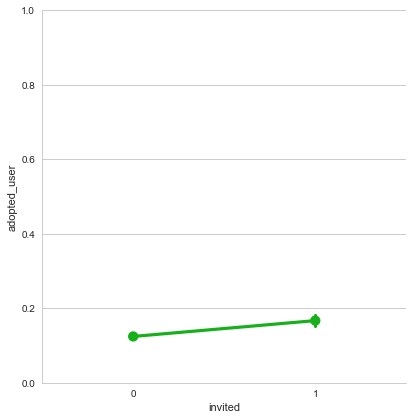

In [11]:
# plot Adopted user frequency by invitation

g = sns.PairGrid(data=users, x_vars=['invited'], y_vars='adopted_user', size=6)
g.map(sns.pointplot, color=sns.xkcd_rgb["green"])
g.set(ylim=(0, 1))

People who have invited other users have a slightly larger chance of being an adopted user.

In [12]:
def stacked_bar(feature):
    ctab = pd.crosstab([users[feature]], users['adopted_user'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab.plot(kind='bar', stacked=True, legend=False)

In [13]:
users['email'] = users['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
users['email'] = users['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

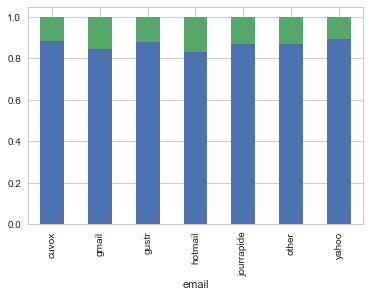

In [14]:
# plot email type for user adoption ratio.

stacked_bar('email')

People who have signed up using **hotmail** are most likely to become adopted users whereas people with **yahoo** IDs are the least likely. However, since the difference is so small, it might be entirely possible that these observations are due to noise.

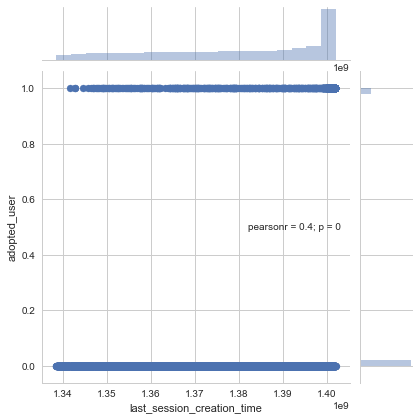

In [15]:
sns.jointplot(x='last_session_creation_time', y='adopted_user', data=users)

There is a correlation between the last session creation time and the target variable adopted user. This may be the most important feature to predcit our adopted users as all the other variables have been extremely weak in explaining the target variable. we will check thsi further using feature variable.

## Feature Engineering

Lets first try to encode the categorical features into the binaory mode using hot encoding.

In [16]:
df = users.set_index('object_id')
df = df.drop('name', axis=1)
df['email'].value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [17]:
df = df.drop('invited_by_user_id', axis=1)
df['org_id'].value_counts().shape
df[df['adopted_user'] == 1]['org_id'].value_counts().shape

(400,)

In [18]:
df = df.drop('org_id', axis=1)
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [19]:
df = df.drop('creation_time', axis=1)
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [20]:
df = pd.get_dummies(df, prefix='is')
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())

In [21]:
df.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,invited,is_cuvox,is_gmail,is_gustr,is_hotmail,is_jourrapide,...,is_3,is_4,is_5,is_6,is_7,is_8,is_9,is_2012,is_2013,is_2014
object_id,,,,,,,,,,,,,,,,,,,,,
1,1.398139e+09,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1.396238e+09,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.363735e+09,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1.369210e+09,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,1.358850e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Machine Learning

In [22]:
X, y = df.drop('adopted_user', axis=1), df['adopted_user']

In [23]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [24]:
# This is a classification probelm to identify if a user will be converted as adopted user or not. 
# Trying Gradient boost classifier 

classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           0.6592            1.21s
         2           0.5922            1.16s
         3           0.5444            1.17s
         4           0.5077            1.15s
         5           0.4780            1.14s
         6           0.4533            1.15s
         7           0.4328            1.12s
         8           0.4158            1.11s
         9           0.4009            1.10s
        10           0.3854            1.10s
        20           0.3019            1.01s
        30           0.2682            0.97s
        40           0.2319            0.86s
        50           0.2115            0.73s
        60           0.2004            0.59s
        70           0.1919            0.43s
        80           0.1820            0.29s
        90           0.1741            0.14s
       100           0.1689            0.00s


0.9688888888888889

In [25]:
confusion_matrix(test_y, classifier.predict(test_X))

array([[1552,    8],
       [  48,  192]])

In [26]:
classifier.feature_importances_.shape

(31,)

In [27]:
features = pd.Series(classifier.feature_importances_, index=X.columns)

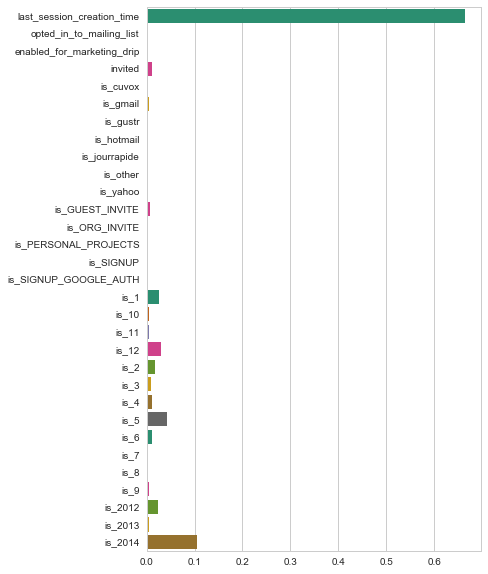

In [28]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_, palette = 'Dark2')

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(train_X, train_y)
result = rf_clf.predict(test_X)

print(np.mean(result == test_y))

print("confusion matrix: ",confusion_matrix(test_y, result))
print("classification report: ", classification_report(test_y, result))
accuracy = accuracy_score(test_y, result)
print(accuracy)

0.9611111111111111
confusion matrix:  [[1542   18]
 [  52  188]]
classification report:               precision    recall  f1-score   support

          0       0.97      0.99      0.98      1560
          1       0.91      0.78      0.84       240

avg / total       0.96      0.96      0.96      1800

0.9611111111111111


## Conclusion

From the analysis and the predictive modeling that we have performed above, the results can be summarized as follows:

* **last_session_creation_time** is the most important feature when it comes to predicting adopted users. It accounts for close to 70% of the importance in Gradient Boosting Classifier.
* **Year and Month** of account created is the next most important information. However, its importance is negligible compared to last login time. New user are more likely yo be converted as adopted users.
* All the other features have close to zero importance and do not explain the target variable well. 


* Further analysis can be done by using random forest classifier with different no of features as parameter and a 5 fold cross validation technique. 
